# Dealing with multi-channels audio file

In [1]:
import pprint

import matplotlib.pyplot as plt

from cutcutcodec.core.classes.layout import AllLayouts
from cutcutcodec.core.compilation.export.compatibility import Compatibilities
from cutcutcodec.core.filter.audio.equation import FilterAudioEquation
from cutcutcodec.core.filter.audio.subclip import FilterAudioSubclip
from cutcutcodec.core.generation.audio.equation import GeneratorAudioEquation
from cutcutcodec.core.io import write

## All supported audio layouts

### Layouts and channels signification and convention

In [2]:
# all supported layout by cutcutcodec
pprint.pprint(AllLayouts().layouts, compact=True)

{'2.1': ('fl', 'fr', 'lfe'),
 '22.2': ('fl', 'fr', 'fc', 'lfe', 'bl', 'br', 'flc', 'frc', 'bc', 'sl', 'sr',
          'tc', 'tfl', 'tfc', 'tfr', 'tbl', 'tbc', 'tbr', 'lfe2', 'tsl', 'tsr',
          'bfc', 'bfl', 'bfr'),
 '3.0': ('fl', 'fr', 'fc'),
 '3.0(back)': ('fl', 'fr', 'bc'),
 '3.1': ('fl', 'fr', 'fc', 'lfe'),
 '3.1.2': ('fl', 'fr', 'fc', 'lfe', 'tfl', 'tfr'),
 '4.0': ('fl', 'fr', 'fc', 'bc'),
 '4.1': ('fl', 'fr', 'fc', 'lfe', 'bc'),
 '5.0': ('fl', 'fr', 'fc', 'bl', 'br'),
 '5.0(side)': ('fl', 'fr', 'fc', 'sl', 'sr'),
 '5.1': ('fl', 'fr', 'fc', 'lfe', 'bl', 'br'),
 '5.1(side)': ('fl', 'fr', 'fc', 'lfe', 'sl', 'sr'),
 '5.1.2': ('fl', 'fr', 'fc', 'lfe', 'bl', 'br', 'tfl', 'tfr'),
 '5.1.4': ('fl', 'fr', 'fc', 'lfe', 'bl', 'br', 'tfl', 'tfr', 'tbl', 'tbr'),
 '6.0': ('fl', 'fr', 'fc', 'bc', 'sl', 'sr'),
 '6.0(front)': ('fl', 'fr', 'flc', 'frc', 'sl', 'sr'),
 '6.1': ('fl', 'fr', 'fc', 'lfe', 'bc', 'sl', 'sr'),
 '6.1(back)': ('fl', 'fr', 'fc', 'lfe', 'bl', 'br', 'bc'),
 '6.1(front)': ('f

In [3]:
# the significance of each channel abreviation
pprint.pprint(AllLayouts().individuals)

{'bc': 'back center',
 'bfc': 'bottom front center',
 'bfl': 'bottom front left',
 'bfr': 'bottom front right',
 'bl': 'back left',
 'br': 'back right',
 'dl': 'downmix left',
 'dr': 'downmix right',
 'fc': 'front center',
 'fl': 'front left',
 'flc': 'front left-of-center',
 'fr': 'front right',
 'frc': 'front right-of-center',
 'lfe': 'low frequency',
 'lfe2': 'low frequency 2',
 'sdl': 'surround direct left',
 'sdr': 'surround direct right',
 'sl': 'side left',
 'sr': 'side right',
 'tbc': 'top back center',
 'tbl': 'top back left',
 'tbr': 'top back right',
 'tc': 'top center',
 'tfc': 'top front center',
 'tfl': 'top front left',
 'tfr': 'top front right',
 'tsl': 'top side left',
 'tsr': 'top side right',
 'wl': 'wide left',
 'wr': 'wide right'}


### Audio layout and codec compatibility

In [4]:
pprint.pprint(Compatibilities().codecs_audio(layout="5.1"), compact=True)


esting encoder/muxer: 100%|███████████████████████████████████| 14700/14700 [00:01<00:00, 12786.27comb/s]

{'aac': [('aac', '3g2'), ('aac', '3gp'), ('aac', 'adts'), ('aac', 'asf'),
         ('aac', 'avi'), ('aac', 'f4v'), ('aac', 'flv'), ('aac', 'ipod'),
         ('aac', 'ismv'), ('aac', 'matroska'), ('aac', 'mov'), ('aac', 'mp4'),
         ('aac', 'mpegts'), ('aac', 'nut'), ('aac', 'rm'), ('aac', 'w64'),
         ('aac', 'wav'), ('aac', 'wtv')],
 'aac_latm': [('aac', 'latm')],
 'alac': [('alac', 'caf'), ('alac', 'ipod'), ('alac', 'ismv'),
          ('alac', 'matroska'), ('alac', 'mov'), ('alac', 'mp4')],
 'mlp': [('mlp', 'matroska'), ('mlp', 'mlp')],
 'vorbis': [('libvorbis', 'asf'), ('libvorbis', 'avi'), ('libvorbis', 'ismv'),
            ('libvorbis', 'matroska'), ('libvorbis', 'mp4'),
            ('libvorbis', 'nut'), ('libvorbis', 'oga'), ('libvorbis', 'ogg'),
            ('libvorbis', 'ogv'), ('libvorbis', 'opus'), ('libvorbis', 'spx'),
            ('libvorbis', 'w64'), ('libvorbis', 'wav'), ('libvorbis', 'webm'),
            ('libvorbis', 'wtv')],
 'wavpack': [('wavpack', 'matroska')

## Create multi-channel streams

In [5]:
stream_stereo = GeneratorAudioEquation(
    "sin(2*pi*220*t)*sin(2*pi*1*t)**2", "sin(2*pi*220*t)*cos(2*pi*1*t)**2"
).out_streams[0]
stream_3_1 = GeneratorAudioEquation(
    "sin(2*pi*440*t)",  # fl
    "cos(2*pi*440*t)",  # fr
    "sin(2*pi*523*t)",  # fc
    "sin(2.pi*27.5*t)",  # lfe
    layout="3.1",
).out_streams[0]

### Combine the channels of the different streams

In [6]:
mix = FilterAudioEquation(  # mix the channels as a 5.1 layer ('fl', 'fr', 'fc', 'lfe', 'bl', 'br'),
    [stream_stereo, stream_3_1],
    "(fl_0+fl_1)/2",  # fl
    "(fl_0+fl_1)/2",  # fr
    "0.8*fc_1 + 0.1*fl_0 + 0.1*fr_0",  # fc
    "lfe_1",  # lfe
    "(fl_0+fl_1)/2",  # bl
    "(fr_0+fr_1)/2",  # br
).out_streams[0]

In [7]:
frame = mix.snapshot(0, 44100, 1024)  # time, sample rate, nbr samples

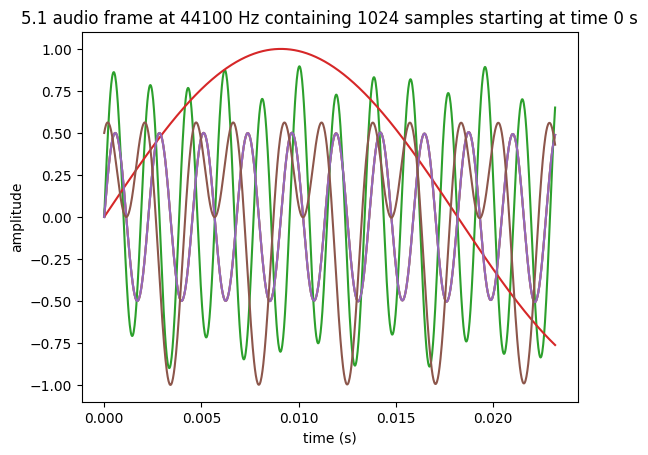

In [8]:
plt.plot(frame.timestamps, frame.T)
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(
    f"{frame.layout.name} audio frame at {frame.rate} Hz "
    f"containing {frame.samples} samples starting at time {frame.time} s"
)
plt.show()

## Write a multichannels audio file

In [9]:
mix_cut = FilterAudioSubclip([mix], 0, 10).out_streams[0]  # select the 10 first seconds
write([mix_cut], "/tmp/audio_5.1.opus", [{"encodec": "libvorbis", "rate": 44100}])


ncoding audio_5.1.opus: 100%|███████████████████████████████████████████████| 10.00s/10.00s [00:00<00:00]